# Accelerating GPT-2 model

### *(and any decoder based transformer models)*

Two trends ongoing in the NLP ecosystem: bigger language model and better text generation. Those trends are game changers (zero shot, etc.) and bring their own challenge: how to perform inference with them? At what cost? GPU or CPU ? etc. aka, how to leverage them in real life?

That’s what we worked on recently, and below you will find the main lessons learned :
* memory IO is by far the main perf bottleneck
* Standard API of ONNX Runtime should not be used but there is an undocumented way of using another ONNX Runtime API which works well
* Nvidia TensorRT is always the fastest option on GPU, by a large margin (expected)
* Caching K/V token representation does not bring any inference optimization (unexpected)

First, let's remind how decoder models work...

Generative text language models like GPT-2 produce text 1 token at a time. The model is auto regressive meaning that each produced token is part of the generation of the next token. There are mainly 2 blocks: the language model itself which produces big tensors, and the decoding algorithm which consumes the tensors and selects 1 or more tokens. Keep in mind that these blocks may live on different hardware… (spoiler: it’s not a good idea)


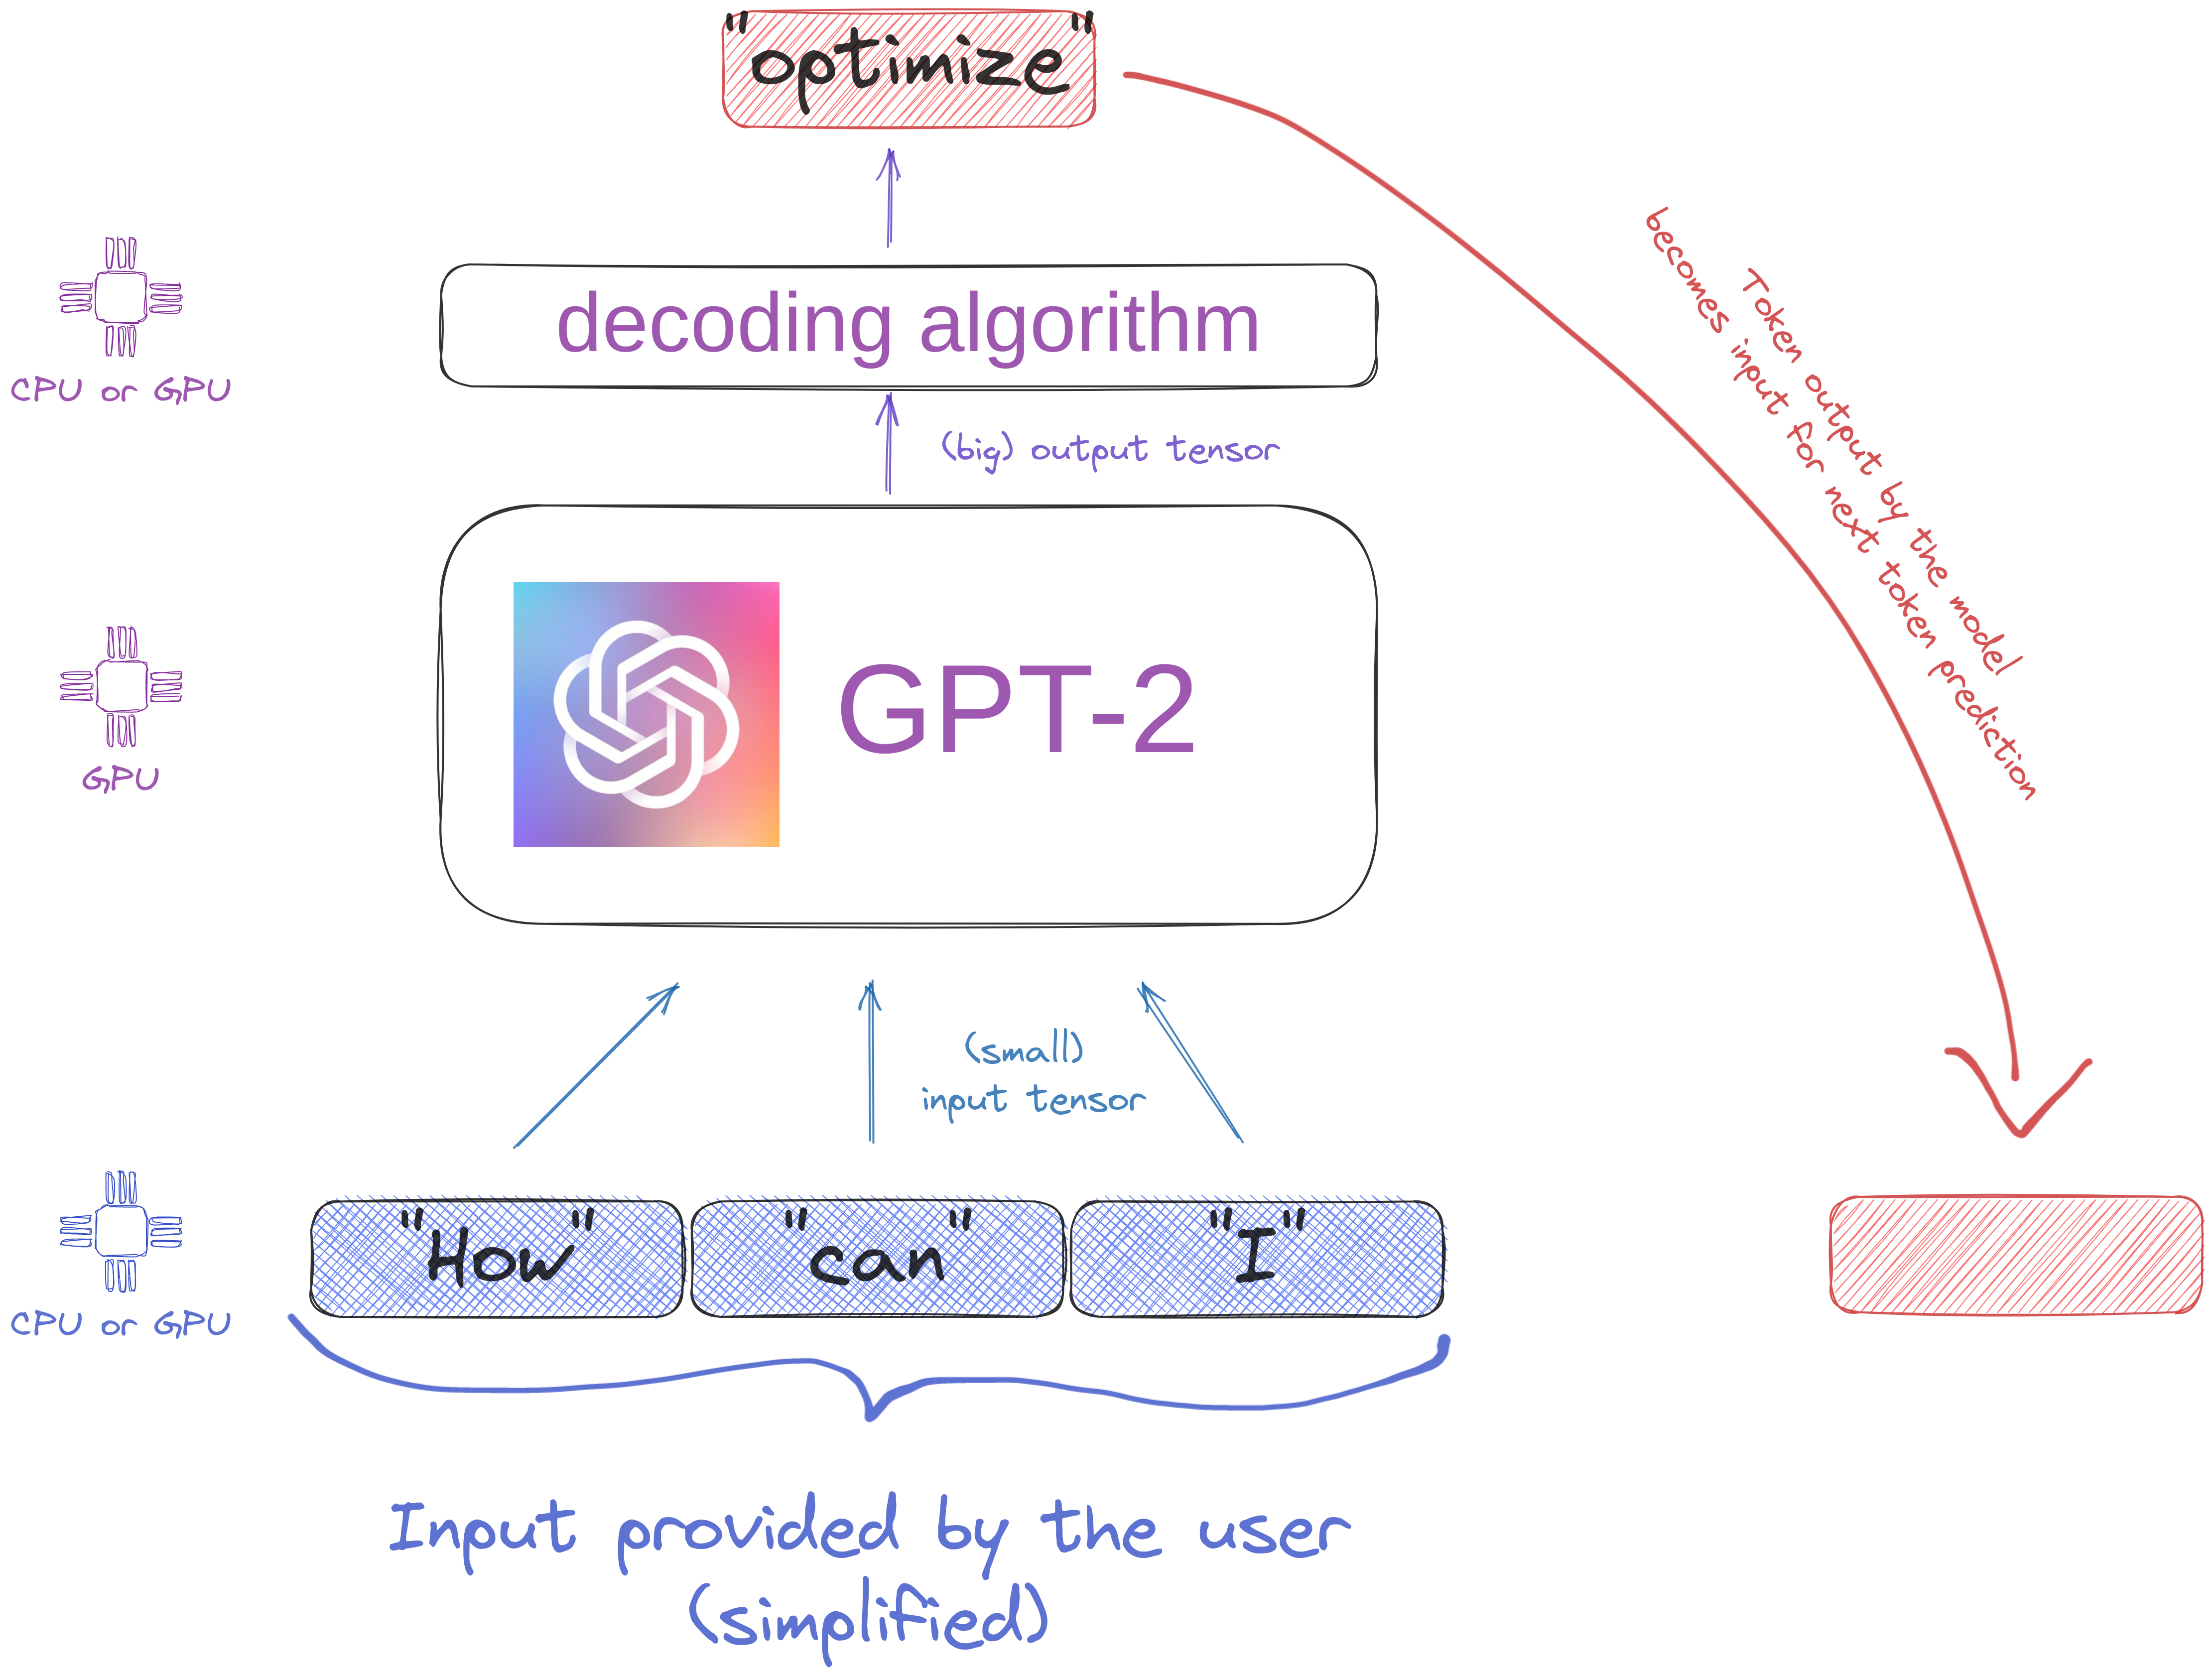

In [1]:
from IPython.display import Image

Image("../../resources/img/gpt2.png")

## GPT-2 loading

As a reminder:

* `gpt2`: 117M parameters
* `gpt2-large` 774M parameters

In [2]:
! nvidia-smi

Tue May 24 16:18:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:03:00.0  On |                  N/A |
| 45%   45C    P8    40W / 350W |    400MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import logging
import time
from typing import Callable, Dict

import numpy as np
import tensorrt as trt
import torch
from tensorrt import ICudaEngine
from tensorrt.tensorrt import Logger, Runtime
from transformers import AutoTokenizer, BatchEncoding, GPT2LMHeadModel, AutoModelForCausalLM
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
from transformer_deploy.utils.generative_model import GPTModelWrapper
import inspect
from transformers import TensorType

from transformer_deploy.backends.ort_utils import create_model_for_provider, inference_onnx_binding, optimize_onnx
from transformer_deploy.backends.pytorch_utils import convert_to_onnx, get_model_size
from transformer_deploy.backends.trt_utils import build_engine, load_engine, save_engine

In [4]:
model_name = "gpt2"  # choices: gpt2 | gpt2-large

# use GPT2LMHeadModel and not AutoModel to export raw outputs to predict next token
model: GPT2LMHeadModel = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)
# to avoid error message or passing some args to each generate call
model.config.pad_token_id = tokenizer.eos_token_id

### Model output

GPT-2 is trained to generate the probability for the next token.
Then a decoding algorithm will consume this information and choose a token:
- greedy decoding will just choose the token getting the highest score
- beam search decoding will explore several possible sequences by keeping track of a limited set of tokens

Below we output predictions for the next token.
Output shape is: `[batch size, nb input tokens, vocabulary size]`

In [5]:
inputs = tokenizer("Here is some text to encode Hello World", return_tensors="pt")
print("input tensors")
print(inputs)
print("input tensor shape")
print(inputs["input_ids"].size())

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print("output tensor")
print(logits)
print("output shape")
print(logits.shape)

input tensors
{'input_ids': tensor([[ 4342,   318,   617,  2420,   284, 37773, 18435,  2159]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
input tensor shape
torch.Size([1, 8])
output tensor
tensor([[[ -34.3027,  -33.9891,  -37.5683,  ...,  -42.6734,  -42.0399,
           -34.6136],
         [ -83.3065,  -82.9769,  -86.1204,  ...,  -89.8062,  -89.4546,
           -83.6084],
         [ -91.4901,  -92.5655,  -95.6423,  ...,  -96.6183,  -98.1545,
           -91.5266],
         ...,
         [ -92.8820,  -94.8433,  -98.9224,  ..., -101.4426, -103.2702,
           -95.7642],
         [ -72.6140,  -76.3407,  -79.7973,  ...,  -87.3300,  -85.7930,
           -77.7521],
         [-103.6147, -108.7898, -109.6276,  ..., -116.8557, -116.5565,
          -107.4467]]])
output shape
torch.Size([1, 8, 50257])


### Total tensor size (input+output)

GPT-2 will generate a sequence 1 token at a time.
So to generates 256 tokens from an 8 tokens prompt, it will perform 248 inferences.

To simplify things, we assume that we are using a greedy decoding algorithm.
If you want to know more about decoding algorithm check this [article](https://huggingface.co/blog/how-to-generate).
Let's compute the total size of the output tensor.

In [6]:
size = 0
for i in range(8, 256, 1):
    # input sequence (input_ids) made of int-32 (4 bytes)
    size += np.prod([1, i]) * 4
    # output tensor made of float-32 (4 bytes)
    size += np.prod([1, i, 50257]) * 4
print(f"total size (input+output): {size / 1024**3:.2f} Gb")

# to manually check actual tensor size:
# np.prod(logits.shape)*32/8/1024**2:.2f}
# or
# sys.getsizeof(logits.storage())/1024**2

total size (input+output): 6.11 Gb


Over 6Gb is a lot of data.
We will see later than naive approach makes these data move from GPU to host and then from host to GPU.
Therefore we are moving 12Gb of data.
Let's keep the order of magnitude in mind when we will try to optimize GPT-2 inference.

## Build ONNX graph

Performant inference engines tend to consume graph instead of imperative Pytorch code. We use ONNX for that purpose.

> ONNX is an open format built to represent machine learning models. ONNX defines a common set of operators - the building blocks of machine learning and deep learning models - and a common file format to enable AI developers to use models with a variety of frameworks, tools, runtimes, and compilers.
> https://onnx.ai/

In [7]:
input_ids: BatchEncoding = tokenizer(
    "Here is some text to encode Hello World", add_special_tokens=True, return_attention_mask=False, return_tensors="pt"
)
# some inference engines don't support int64 tensor as inputs, we convert all input tensors to int32 type
for k, v in input_ids.items():  # type: str, torch.Tensor
    input_ids[k] = v.type(dtype=torch.int32)

convert_to_onnx(
    model_pytorch=model,
    output_path="test-gpt2.onnx",
    inputs_pytorch=dict(input_ids),
    quantization=False,
    var_output_seq=True,  # we inform ONNX export tool that the output shape will vary with the input shape
)
# model may switch to train mode for some unknown reasons, we force the eval mode.
_ = model.eval()

### Optimize ONNX graph

ONNX Runtime optimizations are offline operations to simplify the computation graph.
Some make the computation itself faster (like approximating GELU) but most of them are targeting memory transfer (kernel fusion will perform a series of computations in a single pass, avoiding reading/writing several times the same array, etc.).

In [8]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
num_attention_heads, hidden_size = get_model_size(path=model_name)
optimize_onnx(
    onnx_path="test-gpt2.onnx",
    onnx_optim_model_path="test-gpt2-opt.onnx",
    fp16=True,
    use_cuda=True,
    num_attention_heads=num_attention_heads,
    hidden_size=hidden_size,
    architecture="gpt2",
)

INFO:fusion_utils:Removed 13 Cast nodes with output type same as input
INFO:fusion_base:Fused LayerNormalization count: 25
INFO:fusion_base:Fused FastGelu count: 12
INFO:fusion_utils:Remove reshape node Reshape_9 since its input shape is same as output: ['batch_size', 'sequence']
INFO:fusion_utils:Remove reshape node Reshape_17 since its input shape is same as output: [1, 'sequence']
INFO:fusion_utils:Remove reshape node Reshape_2466 since its input shape is same as output: ['batch_size', 'sequence', 768]
INFO:onnx_model:Graph pruned: 0 inputs, 0 outputs and 739 nodes are removed
INFO:onnx_model_gpt2:postprocess: remove Reshape count:72
INFO:fusion_base:Fused FastGelu(add bias) count: 12
INFO:onnx_model_bert:opset version: 13
INFO:onnx_model_bert:Optimized operators:{'EmbedLayerNormalization': 0, 'Attention': 0, 'Gelu': 0, 'FastGelu': 12, 'BiasGelu': 0, 'LayerNormalization': 25, 'SkipLayerNormalization': 0}
INFO:root:optimizations applied: {'EmbedLayerNormalization': 0, 'Attention': 0,

## Build TensorRT engine

This operation will take the original ONNX graph (before ONNX Runtime optimizations) and optimize it the Nvidia way.
The nature of the graph optimization is similar (approximation and kernel fusion)
One of difference with ONNX Runtime is that these optimizations are benchmarked online on the real hardware, it's called kernel mapping (find the right kernel for specific data shape+model+hardware).
It takes more time to optimize but at the end it is usually much faster.

In [9]:
from pathlib import Path

trt_logger: Logger = trt.Logger(trt.Logger.ERROR)
runtime: Runtime = trt.Runtime(trt_logger)
trt_model_name = "test-gpt2.plan"

# create only of does not exist because it's slow to run...
if not Path(trt_model_name).exists():
    engine: ICudaEngine = build_engine(
        runtime=runtime,
        onnx_file_path="test-gpt2.onnx",
        logger=trt_logger,
        min_shape=(1, 1),
        optimal_shape=(1, 128),  # num beam, batch size
        max_shape=(1, 384),  # num beam, batch size
        workspace_size=10000 * 1024**2,
        fp16=True,
        int8=False,
    )
    save_engine(engine, trt_model_name)

## End to end text generation benchmarks (inference+decoding)

We will benchmark 3 inference engines:
* **Pytorch**: Hugging Face implementation
* **ONNX Runtime**:
    * with optimized ONNX graph and `standard API`: tensors stored as `numpy` objects, on host RAM
    * with optimized ONNX graph and `binding IO API`: tensors stored on CUDA, to limit IO
* **Nvidia TensorRT**: tensors stored on CUDA, to limit IO

For each of them, we print the output of the result so we can check that it generates the same sequence.
Then we measure inference latency.

### Generative model wrapper

To replace Pytorch as inference engine and still use Hugging Face decoding algorithm, we use a wrapping class which separate those tasks.

The most interesting thing in the class below is that we inherit from `GenerationMixin` (from Hugging Face transformers library), it will give our class some super-powers like a method to generate sequences (aka running some decoding algorithm on top of the model output).
Note that the actual model inference is done by a function provided through the constructor.

In [10]:
print(inspect.getsource(GPTModelWrapper))

class GPTModelWrapper(Module, GenerationMixin):
    def __init__(
        self, config: PretrainedConfig, device: torch.device, inference: Callable[[torch.Tensor], torch.Tensor]
    ):
        super().__init__()
        self.config: PretrainedConfig = config
        self.device: torch.device = device
        self.inference: Callable[[torch.Tensor], torch.Tensor] = inference
        self.main_input_name = "input_ids"  # https://github.com/huggingface/transformers/pull/14803

    def prepare_inputs_for_generation(self, input_ids, **kwargs):
        return {
            self.main_input_name: input_ids,
        }

    def forward(self, input_ids, **_):
        logits = self.inference(input_ids)
        return CausalLMOutputWithCrossAttentions(logits=logits)



In [11]:
inputs = tokenizer(
    "Here is some text to encode Hello World",  # Nvidia example prompt
    add_special_tokens=True,
    return_attention_mask=False,  # Not used
    return_tensors=TensorType.PYTORCH,
)
inputs

{'input_ids': tensor([[ 4342,   318,   617,  2420,   284, 37773, 18435,  2159]])}

### Pytorch inference

We first measure vanilla Hugging face implementation with Pytorch backend.
It will be our baseline.

In [12]:
def inference_torch(input_ids: torch.Tensor) -> torch.Tensor:
    transformer_outputs: BaseModelOutputWithPastAndCrossAttentions = model.transformer(input_ids=input_ids)
    return model.lm_head(transformer_outputs.last_hidden_state)


model.cuda()
model.eval()
inputs.to("cuda")
with torch.inference_mode():
    gpt2_model = GPTModelWrapper(config=model.config, device=model.device, inference=inference_torch)
    sample_output = gpt2_model.generate(inputs.input_ids, max_length=64)
    print(tokenizer.decode(sample_output[0], skip_special_tokens=False))
    for _ in range(2):
        _ = gpt2_model.generate(inputs.input_ids, max_length=64)
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(10):
        _ = gpt2_model.generate(inputs.input_ids, max_length=256)
        torch.cuda.synchronize()
    print(f"----\nPytorch: {(time.time() - start)/10:.2f}s/sequence")
_ = model.cpu()

Here is some text to encode Hello World.

Hello World

Hello World is a simple program that takes a string and returns a string.

The program is written in C.

The program is written in C. The program is written in C. The program is written in C. The program
----
Pytorch: 2.13s/sequence


### Naive ONNX Runtime inference

Below we use `ONNX Runtime` and its standard API.
Inference is performed on GPU (CUDA provider in the ONNX Runtime ecosystem).

It takes as input and return as output a `numpy` tensor.
`numpy` tensor are by their nature always stored on host memory (RAM).

It means that for each token the whole output tensor is moved from GPU memory to host.
As measure above, it represents more than 2X6Gb of memory transfers between host and GPU memory.

In our code, we convert the output `numpy` tensor to `Pytorch` one so it can be consumed by the Hugging Face decoding algorithm.
ONNX model used is the optimized one (kernel fusion + fp16).

In [13]:
model_onnx = create_model_for_provider(path="test-gpt2-opt.onnx", provider_to_use="CUDAExecutionProvider")


def inference_onnx_naive(input_ids: torch.Tensor) -> torch.Tensor:
    data = {"input_ids": input_ids.detach().cpu().numpy().astype(np.int32)}
    logit = model_onnx.run(None, data)
    np_logit = np.array(logit)  # convert list of numpy arrays to a numpy array
    # we convert numpy tensor to Pytorch tensor as it's the type expected by HF decoding algorithm
    return torch.squeeze(torch.from_numpy(np_logit), dim=0)


gpt2_model = GPTModelWrapper(config=model.config, device=torch.device("cpu"), inference=inference_onnx_naive)
inputs.to("cpu")
sample_output = gpt2_model.generate(inputs.input_ids, max_length=64)
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))
for _ in range(2):
    _ = gpt2_model.generate(inputs.input_ids, max_length=64)
start = time.time()
for _ in range(10):
    _ = gpt2_model.generate(inputs.input_ids, max_length=256)
print(f"----\nONNX Runtime (standard API): {(time.time() - start)/10:.2f}s/sequence")

del model_onnx

Here is some text to encode Hello World.

Hello World

Hello World is a simple program that takes a string and returns a string.

The program is written in C.

The program is written in C. The program is written in C. The program is written in C. The program
----
ONNX Runtime (standard API): 3.38s/sequence


No surprise, the generation is slower than vanilla Pytorch, even after having optimized the ONNX model.

### Optimized ONNX Runtime inference (no GPU <-> host tensor move)

In this benchmark, we use ONNX Runtime and its `binding IO API`.
The way it works inside (`inference_onnx_binding` code) is that we basically provide to the API a pointer to Pytorch tensor storage array.
The storage array is a CUDA array (in our case) containing the tensor data themselves, the tensor abstraction adds some meta data to this array.

Therefore ONNX Runtime can directly write output in the Pytorch tensor without using any `numpy` array (stored in host RAM).
Because Hugging Face decoding algorithm can run on CUDA too, we do not move any data to host.

By just removing memory movement, we reduce the inference time by a large margin.

> **Warning**
> if you want to use this ONNX Runtime API, don't forget to make your tensor contiguous in memory (not shown here because it is done by the `transformer-deploy` library).
> Another point to have in mind is that you need to reserve manually GPU memory... and unlike TensorRT, ONNX Runtime is not able to predict output shape, so you need to have the output size logic elsewhere.

In [14]:
model_onnx = create_model_for_provider(path="test-gpt2-opt.onnx", provider_to_use="CUDAExecutionProvider")


def inference_onnx_optimized(input_ids: torch.Tensor) -> torch.Tensor:
    data = {"input_ids": input_ids}
    return inference_onnx_binding(model_onnx=model_onnx, inputs=data, device="cuda")["output"]


gpt2_model = GPTModelWrapper(config=model.config, device=torch.device("cuda"), inference=inference_onnx_optimized)
inputs.to("cuda")
sample_output = gpt2_model.generate(inputs.input_ids, max_length=64)
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))
for _ in range(2):
    _ = gpt2_model.generate(inputs.input_ids, max_length=64)
start = time.time()
for _ in range(10):
    _ = gpt2_model.generate(inputs.input_ids, max_length=256)
print(f"----\nONNX Runtime (binding io API): {(time.time() - start)/10:.2f}/sequence")
del model_onnx

Here is some text to encode Hello World.

Hello World

Hello World is a simple program that takes a string and returns a string.

The program is written in C.

The program is written in C. The program is written in C. The program is written in C. The program
----
ONNX Runtime (binding io API): 0.85/sequence


Good news: the output is the same than Pytorch, and still inference time is much faster.

### TensorRT Inference

To conclude, we use the Nvidia engine, all tensors are stored on CUDA.
Unlike ONNX Runtime, each optimization applied has been checked on the target GPU with the expected tensor shape.
It explains most of its performance compared to ONNX Runtime optimized performances.

In [15]:
tensorrt_model: Callable[[Dict[str, torch.Tensor]], torch.Tensor] = load_engine(
    engine_file_path="test-gpt2.plan", runtime=runtime
)


def inference_tensorrt(input_ids: torch.Tensor) -> torch.Tensor:
    data = {"input_ids": input_ids}
    return tensorrt_model(data)


gpt2_model = GPTModelWrapper(config=model.config, device=torch.device("cuda"), inference=inference_tensorrt)
inputs.to("cuda")
sample_output = gpt2_model.generate(inputs.input_ids, max_length=64)
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))
for _ in range(2):
    _ = gpt2_model.generate(inputs.input_ids, max_length=64)
start = time.time()
for _ in range(10):
    _ = gpt2_model.generate(inputs.input_ids, max_length=256)
print(f"----\nTensorRT + CUDA tensors: {(time.time() - start)/10:.2f}/sequence")

del tensorrt_model

Here is some text to encode Hello World.

Hello World

Hello World is a simple program that takes a string and returns a string.

The program is written in C.

The program is written in C. The program is written in C. The program is written in C. The program
----
TensorRT + CUDA tensors: 0.49/sequence


## Is caching of Key / Values in self-attention block (Transformer architecture) a good strategy on GPU?

In the self-attention block, the first step is to compute query, key and value vectors for each input token.
For each token, we look up its embedding in the embedding matrix and adds to it a positional encoding so the model knows word order.
Then we multiply each of these token representation by 3 matrices: query (Q), key (K), and value (V).
These matrices are then transposed, with Q<sup>T</sup> and K<sup>T</sup> being used to compute the normalized dot-product attention values, before being combined with V<sup>T</sup> to produce the final output.

This computation is done for each self-attention block (as each of them has its own "memory").
In a generative model, we need to recompute those values for each generated token.

For a specific input token, the result won't change from one inference to the next one, it may be interesting to cache and reuse the results instead of recomputing it.

However, this won't come for free as we would need 2 ONNX / TensorRT models, one generating the values for the first time (to boot the sequence generation), and one able to reuse the cached values. It means 2X bigger memory footprint on GPU :-(

But first, let's measure the gain in performance of caching values, if any.

In [16]:
model.cuda()
model.eval()
inputs.to("cuda")
with torch.inference_mode():
    for _ in range(2):
        _ = model.generate(inputs.input_ids, max_length=64, use_cache=True)
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(2):
        _ = model.generate(inputs.input_ids, max_length=256, use_cache=True)
        torch.cuda.synchronize()
    print(f"Pytorch with cache: {(time.time() - start)/2:.2f}s/sequence")

    for _ in range(2):
        _ = model.generate(inputs.input_ids, max_length=64, use_cache=False)
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(2):
        _ = model.generate(inputs.input_ids, max_length=256, use_cache=False)
        torch.cuda.synchronize()
    print(f"Pytorch without cache: {(time.time() - start)/2:.2f}s/sequence")

_ = model.cpu()

Pytorch with cache: 2.13s/sequence
Pytorch without cache: 2.17s/sequence


Suprinsingly, cache support or not, on Pytorch, with an end-to-end test, for a 256 sequence length and when inference is performed on a last generation GPU (at the time of writing), latencies are very similar.
Expect different results on older/slower GPU like Nvidia T4 (cache may help more).

> Not shown in this notebook to keep it "light", on fast GPU, for very long sequences (like 1024 tokens), on Pytorch, cache support provides better performances, but optimized ONNX Runtime / TensorRT engines without cache support are still faster.

To dig a bit more, we will measure inference engines with fixed input sizes.

### Export an ONNX model able to reuse cache

To simplify the code, we just use the ONNX exporter tool from Hugging Face library (it's a far from perfect tool, in this case it's okish, in general be prudent in using it).

In [17]:
from itertools import chain
from torch.onnx import export
from transformers.models.gpt2 import GPT2OnnxConfig
from transformers.onnx.features import FeaturesManager

model_name = "gpt2"
feature = "causal-lm-with-past"
seq_len = 256
atol = 0.2

tokenizer = AutoTokenizer.from_pretrained(model_name)
model: GPT2LMHeadModel = FeaturesManager.get_model_from_feature(feature, model_name)
model_kind, model_onnx_config = FeaturesManager.check_supported_model_or_raise(model, feature=feature)
onnx_config: GPT2OnnxConfig = model_onnx_config(model.config)

with torch.no_grad():
    model.config.return_dict = True
    model.eval()

    # Check if we need to override certain configuration item
    if onnx_config.values_override is not None:
        for override_config_key, override_config_value in onnx_config.values_override.items():
            setattr(model.config, override_config_key, override_config_value)

    # Ensure inputs match
    model_inputs = onnx_config.generate_dummy_inputs(tokenizer, framework=TensorType.PYTORCH)
    for k, v in model_inputs.items():
        if isinstance(v, torch.Tensor):
            model_inputs[k] = model_inputs[k].type(torch.int32)
    onnx_outputs = list(onnx_config.outputs.keys())

    onnx_config.patch_ops()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    export(
        model,
        (model_inputs,),
        f="model-support-cache.onnx",
        input_names=list(onnx_config.inputs.keys()),
        output_names=onnx_outputs,
        dynamic_axes={name: axes for name, axes in chain(onnx_config.inputs.items(), onnx_config.outputs.items())},
        do_constant_folding=True,
        opset_version=13,
    )

    onnx_config.restore_ops()

/home/geantvert/.local/share/virtualenvs/fast_transformer/lib/python3.9/site-packages/transformers/models/gpt2/modeling_gpt2.py:796: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if batch_size <= 0:


The ONNX graph with cache support expects as input:
* 1 tensor name `input_ids` of shape `[batch, 1]`
* 12 tensors named `past_key_values.X.key` (X replaced by layer ID) of shape `[batch, nb heads (12), past sequence len, 64]`
* 12 tensors named `past_key_values.X.value` (X replaced by layer ID) of shape `[batch, nb heads (12), past sequence len, 64]`
* 1 tensor named `attention_mask` of shape `[batch, past sequence len + 1]`

To list model inputs (according to their ONNX graph):

In [18]:
import onnx

model_cache = onnx.load("model-support-cache.onnx")
# first 100 lines
text = "\n".join(str(model_cache.graph.input).split("\n")[:80])
print(text)
del model_cache

[name: "input_ids"
type {
  tensor_type {
    elem_type: 6
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_param: "sequence"
      }
    }
  }
}
, name: "past_key_values.0.key"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_value: 12
      }
      dim {
        dim_param: "past_sequence + sequence"
      }
      dim {
        dim_value: 64
      }
    }
  }
}
, name: "past_key_values.0.value"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_value: 12
      }
      dim {
        dim_param: "past_sequence + sequence"
      }
      dim {
        dim_value: 64
      }
    }
  }
}
, name: "past_key_values.1.key"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_value: 12
      }
      dim {
        dim_param: "past_sequence + sequence"
 

### Benchmark ONNX Runtime, CUDA tensors, with cache

When using cache, **we only test non-optimized ONNX models** (no kernel fusion, fp32) as optimization crash in this setup.
It's possibly because ONNX Runtime doesn't find some patterns...

In [19]:
batch = 1
sequence = 256

# input with random values
input_cache = dict()
input_cache["input_ids"] = torch.ones((batch, 1), dtype=torch.int32)
for i in range(12):  # 12 layers
    input_cache[f"past_key_values.{i}.key"] = torch.empty((batch, 12, sequence, 64), dtype=torch.float32)
    input_cache[f"past_key_values.{i}.value"] = torch.empty((batch, 12, sequence, 64), dtype=torch.float32)
input_cache["attention_mask"] = torch.ones((batch, sequence + 1), dtype=torch.int32)

print(f"for {sequence} tokens WITH cache:")
for nb_inference, provider, device in [(10, "CPUExecutionProvider", "cpu"), (100, "CUDAExecutionProvider", "cuda")]:
    model_onnx = create_model_for_provider(path="model-support-cache.onnx", provider_to_use=provider)

    # Pytorch
    model = model.to(device=device, non_blocking=False)
    output_pytorch = model(
        input_ids=torch.ones((batch, sequence), dtype=torch.int32, device=device), past_key_values=None
    )
    pytorch_input = torch.ones((batch, 1), dtype=torch.int32, device=device)
    for i in range(nb_inference):
        _ = model(input_ids=pytorch_input, past_key_values=output_pytorch.past_key_values)
        torch.cuda.synchronize()
    start = time.time()
    for i in range(nb_inference):
        _ = model(input_ids=pytorch_input, past_key_values=output_pytorch.past_key_values)
        torch.cuda.synchronize()
    print(f"[Pytorch / {device.upper()}] {1e3*(time.time() - start)/nb_inference:.2f}ms")

    # naive implementation (tensor copies)
    inputs_ort_np = {k: v.cpu().numpy() for k, v in input_cache.items()}
    # warmup
    for _ in range(nb_inference):
        _ = model_onnx.run(None, inputs_ort_np)
    start = time.time()
    for _ in range(nb_inference):
        _ = model_onnx.run(None, inputs_ort_np)
    print(f"[ONNX Runtime / {device.upper()} - with copy (naive)] {1e3*(time.time() - start)/nb_inference:.2f}ms")

    # ONNX Runtime optimized (no tensor copy)
    inputs = {k: v.to(device) for k, v in input_cache.items()}
    for _ in range(nb_inference):
        inference_onnx_binding(model_onnx=model_onnx, inputs=inputs, device=device)
    start = time.time()
    for _ in range(nb_inference):
        inference_onnx_binding(model_onnx=model_onnx, inputs=inputs, device=device)
    print(f"[ONNX Runtime / {device.upper()} - no copy] {1e3*(time.time() - start)/nb_inference:.2f}ms")

for 256 tokens WITH cache:
[Pytorch / CPU] 23.41ms
[ONNX Runtime / CPU - with copy (naive)] 29.29ms
[ONNX Runtime / CPU - no copy] 28.13ms
[Pytorch / CUDA] 10.40ms
[ONNX Runtime / CUDA - with copy (naive)] 14.18ms
[ONNX Runtime / CUDA - no copy] 5.10ms


First we note that ONNX Runtime with tensor copy is equivalent to Pytorch which keeps all its tensors on GPU.
When we remove the overhead of tensor copies, ONNX Runtime is 1/3 faster compared to Pytorch.
On CPU no copy latency is similar to tensor copy implementation... because tensors are all on host RAM (no host <-> GPU memory transfer).
On GPU, no copy latency is 3 times faster than tensor copies implementation which shows that IO is crucial in this scenario.

We compare outputs of Pytorch and ONNX Runtime, with and without cache:

In [20]:
device = "cuda"
model = model.to(device)
a = model(input_ids=torch.ones((batch, sequence + 1), dtype=torch.int32, device=device), past_key_values=None)
print("pytorch - do not use cache output")
print(a.logits[:, -1, :])
b = model(input_ids=pytorch_input, past_key_values=output_pytorch.past_key_values)
print("pytorch - use cache output")
print(b.logits[:, -1, :])
input_cache = dict()
input_cache["input_ids"] = torch.ones((batch, 1), dtype=torch.int32, device=device)
input_cache["attention_mask"] = torch.ones((batch, sequence + 1), dtype=torch.int32, device=device)
for index, (k, v) in enumerate(output_pytorch.past_key_values):  # type: int, (torch.Tensor, torch.Tensor)
    input_cache[f"past_key_values.{index}.key"] = k
    input_cache[f"past_key_values.{index}.value"] = v
model_onnx = create_model_for_provider(path="model-support-cache.onnx", provider_to_use="CUDAExecutionProvider")
print("ONNX Runtime - use cache output")
print(inference_onnx_binding(model_onnx=model_onnx, inputs=input_cache, device=device)["logits"])

pytorch - do not use cache output
tensor([[-252.7182, -233.3198, -248.5054,  ..., -274.1910, -281.5367,
         -249.9165]], device='cuda:0', grad_fn=<SliceBackward0>)
pytorch - use cache output
tensor([[-252.6881, -233.2935, -248.4776,  ..., -274.1533, -281.4907,
         -249.8890]], device='cuda:0', grad_fn=<SliceBackward0>)
ONNX Runtime - use cache output
tensor([[[-252.6788, -233.2558, -248.4547,  ..., -274.1335, -281.4955,
          -249.8821]]], device='cuda:0')


### Benchmark ONNX Runtime, CUDA tensors, without cache

We compare the following setup, on both CPU and GPU:

- Pytorch
- ONNX Runtime (FP32): `test-gpt2.onnx`
- ONNX Runtime (kernel fusion + FP16): `test-gpt2-opt.onnx`

For ONNX Runtime, we test 2 models, one without kernel fusion and one with it and FP16 precision.

In [21]:
input_cache = dict()
input_cache["input_ids"] = torch.ones((batch, sequence), dtype=torch.int32, device="cuda")

print(f"for {sequence} tokens WITHOUT cache:")
for nb_inference, provider, device in [(10, "CPUExecutionProvider", "cpu"), (100, "CUDAExecutionProvider", "cuda")]:
    inputs = {k: v.to(device) for k, v in input_cache.items()}

    for _ in range(nb_inference):
        _ = model(**input_cache)
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(nb_inference):
        _ = model(**input_cache)
        torch.cuda.synchronize()
    print(f"[Pytorch / {device.upper()}] {1e3*(time.time() - start)/nb_inference:.2f}ms")

    for model_path in ["test-gpt2.onnx", "test-gpt2-opt.onnx"]:
        model_onnx = create_model_for_provider(path=model_path, provider_to_use=provider)

        # naive implementation
        inputs_ort_numpy = {k: v.cpu().numpy() for k, v in input_cache.items()}
        # warmup
        for _ in range(nb_inference):
            _ = model_onnx.run(None, inputs_ort_numpy)
        start = time.time()
        for _ in range(nb_inference):
            _ = model_onnx.run(None, inputs_ort_numpy)
        print(
            f"[ONNX Runtime / {device.upper()} - with copy (naive) - {model_path}] {1e3*(time.time() - start)/nb_inference:.2f}ms"
        )

        # no copy
        for _ in range(nb_inference):
            inference_onnx_binding(model_onnx=model_onnx, inputs=inputs, device=device)
        start = time.time()
        for _ in range(nb_inference):
            inference_onnx_binding(model_onnx=model_onnx, inputs=inputs, device=device)
        print(
            f"[ONNX Runtime / {device.upper()} - no copy - {model_path}] {1e3*(time.time() - start)/nb_inference:.2f}ms"
        )

for 256 tokens WITHOUT cache:
[Pytorch / CPU] 11.32ms
[ONNX Runtime / CPU - with copy (naive) - test-gpt2.onnx] 170.77ms
[ONNX Runtime / CPU - no copy - test-gpt2.onnx] 172.04ms
[ONNX Runtime / CPU - with copy (naive) - test-gpt2-opt.onnx] 361.85ms
[ONNX Runtime / CPU - no copy - test-gpt2-opt.onnx] 370.81ms
[Pytorch / CUDA] 10.94ms
[ONNX Runtime / CUDA - with copy (naive) - test-gpt2.onnx] 15.19ms
[ONNX Runtime / CUDA - no copy - test-gpt2.onnx] 5.14ms
[ONNX Runtime / CUDA - with copy (naive) - test-gpt2-opt.onnx] 12.89ms
[ONNX Runtime / CUDA - no copy - test-gpt2-opt.onnx] 3.46ms


In [22]:
trt_logger: Logger = trt.Logger(trt.Logger.ERROR)
runtime: Runtime = trt.Runtime(trt_logger)
trt_model_name = "test-gpt2.plan"

tensorrt_model: Callable[[Dict[str, torch.Tensor]], torch.Tensor] = load_engine(
    engine_file_path="test-gpt2.plan", runtime=runtime
)
nb_inference = 100
for _ in range(nb_inference):
    tensorrt_model(input_cache)

start = time.time()
for _ in range(nb_inference):
    tensorrt_model(input_cache)
print(f"[TensorRT / {device.upper()} - no copy] {1e3*(time.time() - start)/nb_inference:.2f}ms")

[TensorRT / CUDA - no copy] 2.21ms


The most interesting thing to note is that on ONNX Runtime, without cache and kernel fusion we get similar latency than with cache.
It means that cache overhead is bigger than recomputing the tensors! It's probably the most unexpected result of this experience.

As usual, FP16 models on CPU are slower than FP32.

And to conclude, surprise, TensorRT is the fastest option by a large margin.